In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 6.9 MB/s eta 0:00:00


In [ ]:
# ======== IMPORTS ========
import yfinance as yf
import numpy as np
import pandas as pd
import lightgbm as lgb
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt import objective_functions

In [ ]:
# ======== DATA IMPORT ========
def import_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    returns = data.pct_change().dropna()
    return data, returns

tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA']
prices, returns = import_data(tickers, '2022-01-01', '2025-01-01')



[*********************100%***********************]  5 of 5 completed


In [ ]:
# ======== FEATURE ENGINEERING ========
def create_features(prices):
    features = pd.DataFrame(index=prices.index)
    for ticker in prices.columns:
        # Price-based features
        features[f'{ticker}_MA10'] = prices[ticker].rolling(10).mean()
        features[f'{ticker}_RSI14'] = 100 - (100 / (1 + prices[ticker].diff(1).clip(lower=0).rolling(14).mean() /
                                            prices[ticker].diff(1).clip(upper=0).abs().rolling(14).mean()))
        # Volatility features
        features[f'{ticker}_VOL30'] = prices[ticker].pct_change().rolling(30).std()
        # Technical indicators
        features[f'{ticker}_MACD'] = prices[ticker].ewm(span=12).mean() - prices[ticker].ewm(span=26).mean()
        features[f'{ticker}_BB_U'] = prices[ticker].rolling(20).mean() + 2*prices[ticker].rolling(20).std()
        features[f'{ticker}_BB_L'] = prices[ticker].rolling(20).mean() - 2*prices[ticker].rolling(20).std()
    return features.dropna()

features = create_features(prices)


In [ ]:
print(f"Features index (X): {features.index[:5]}")
print(f"Returns index (y): {returns.index[:5]}")
common_dates = features.index.intersection(returns.index)
print(f"Common dates count: {len(common_dates)}")
print(f"First few common dates: {common_dates[:5]}")


Features index (X): DatetimeIndex(['2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
               '2022-02-22'],
              dtype='datetime64[ns]', name='Date', freq=None)
Returns index (y): DatetimeIndex(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-10'],
              dtype='datetime64[ns]', name='Date', freq=None)
Common dates count: 723
First few common dates: DatetimeIndex(['2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
               '2022-02-22'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
features.index = features.index.strftime('%Y-%m-%d')
returns.index = returns.index.strftime('%Y-%m-%d')
common_dates = features.index.intersection(returns.index)
print(f"Common dates count after fixing: {len(common_dates)}")



Common dates count after fixing: 723


In [ ]:
print(f"NaNs in features: {features.isna().sum().sum()}")
print(f"NaNs in returns: {returns.isna().sum().sum()}")


NaNs in features: 0
NaNs in returns: 0


In [ ]:
  X = features
  y = (returns.shift(-1) > 0).astype(int)  # Next-day return direction

  X, y = X.align(y, join='inner', axis =0)
  print(  X)

             AAPL_MA10  AAPL_RSI14  AAPL_VOL30  AAPL_MACD   AAPL_BB_U  \
Date                                                                    
2022-02-15  169.836671   67.608917    0.019301   0.539859  177.768369   
2022-02-16  169.534938   68.022089    0.019185   0.587623  178.120981   
2022-02-17  169.160999   47.952648    0.018965   0.350732  178.127860   
2022-02-18  168.660114   36.685489    0.018801   0.045697  177.935386   
2022-02-22  167.937817   33.256400    0.019054  -0.412859  177.701655   
...                ...         ...         ...        ...         ...   
2024-12-24  251.014017   76.180657    0.008616   6.067327  259.105495   
2024-12-26  252.265639   76.812079    0.008575   6.300019  260.358798   
2024-12-27  253.027800   69.300685    0.009190   6.137217  260.449258   
2024-12-30  253.434354   58.382055    0.009546   5.669595  260.083639   
2024-12-31  253.372423   53.982582    0.009181   5.096776  259.651778   

             AAPL_BB_L   AMZN_MA10  AMZN_RSI14  AM

In [ ]:
print(X.head(),y.head())

             AAPL_MA10  AAPL_RSI14  AAPL_VOL30  AAPL_MACD   AAPL_BB_U  \
Date                                                                    
2022-02-15  169.836671   67.608917    0.019301   0.539859  177.768369   
2022-02-16  169.534938   68.022089    0.019185   0.587623  178.120981   
2022-02-17  169.160999   47.952648    0.018965   0.350732  178.127860   
2022-02-18  168.660114   36.685489    0.018801   0.045697  177.935386   
2022-02-22  167.937817   33.256400    0.019054  -0.412859  177.701655   

             AAPL_BB_L   AMZN_MA10  AMZN_RSI14  AMZN_VOL30  AMZN_MACD  ...  \
Date                                                                   ...   
2022-02-15  154.543277  155.161050   65.056175    0.035896   0.705722  ...   
2022-02-16  154.833406  155.909850   65.541513    0.035855   0.901530  ...   
2022-02-17  155.277157  157.490549   59.122495    0.035908   0.788833  ...   
2022-02-18  155.971169  156.986749   52.754632    0.035961   0.538899  ...   
2022-02-22  156.4908

In [ ]:
def preprocess(features, returns):
  X = features
  y = (returns.shift(-1) > 0).astype(int)  # Next-day return direction

  target_stock = 'MSFT'  # Choose the stock you want to predict

# Select only columns that belong to the target stock
  X_filtered = X[[col for col in X.columns if col.startswith(target_stock)]].copy()
  y = returns[target_stock].shift(-1)  # Predict next-day movement
  y = (y > 0).astype(int)  # Binary classification (1 = up, 0 = down)
  X, y = X.align(y, join='inner', axis =0)
  return X_filtered,y

preprocess(features, returns)

(             MSFT_MA10  MSFT_RSI14  MSFT_VOL30  MSFT_MACD   MSFT_BB_U  \
 Date                                                                    
 2022-02-15  294.774612   52.506006    0.020206  -1.717620  306.350537   
 2022-02-16  293.476868   50.193315    0.020041  -1.710583  306.205923   
 2022-02-17  292.511990   38.342411    0.019547  -2.318375  306.519102   
 2022-02-18  290.817950   34.555475    0.019566  -2.970058  307.114135   
 2022-02-22  289.588846   35.537862    0.019561  -3.460798  307.638195   
 ...                ...         ...         ...        ...         ...   
 2024-12-24  442.859009   51.898969    0.012107   4.117905  456.500500   
 2024-12-26  441.773184   45.130635    0.011977   3.658435  456.216567   
 2024-12-27  439.873993   37.684143    0.012422   2.653298  455.327768   
 2024-12-30  437.634485   31.144329    0.012654   1.381769  455.103458   
 2024-12-31  434.631506   30.793585    0.011621   0.104701  456.294902   
 
              MSFT_BB_L  
 Date     

In [ ]:
X,y = preprocess(features, returns)
print(len(X),len(y))

723 723


In [ ]:
# ======== LIGHTGBM MODEL TRAINING ========
def train_model(features, returns):
    X = features
    y = (returns.shift(-1) > 0).astype(int)  # Next-day return direction

    X,y = preprocess(features, returns)

    # Select top 50% features using LightGBM importance
    model = lgb.LGBMClassifier()
    model.fit(X, y)
    importance = pd.Series(model.feature_importances_, index=X.columns)
    selected_features = importance.nlargest(int(len(X.columns)*0.5)).index

    # Final training with selected features
    final_model = lgb.LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=100
    )
    final_model.fit(X[selected_features], y)

    return final_model, selected_features

model, selected_features = train_model(features, returns)


[LightGBM] [Info] Number of positive: 373, number of negative: 350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515906 -> initscore=0.063645
[LightGBM] [Info] Start training from score 0.063645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
print(selected_features)

Index(['MSFT_RSI14', 'MSFT_MACD', 'MSFT_VOL30'], dtype='object')


In [ ]:
# yet to be done

# ======== PORTFOLIO OPTIMIZATION WITH CVAR ========
def optimize_portfolio(predicted_probs, prices, cvar_alpha=0.95):
    # Select stocks with positive outlook
    selected_stocks = predicted_probs.columns[predicted_probs.iloc[-1] > 0.5]

    if len(selected_stocks) == 0:
        return pd.Series(0, index=prices.columns)

    # Calculate expected returns and covariance
    mu = expected_returns.mean_historical_return(prices[selected_stocks])
    S = risk_models.sample_cov(prices[selected_stocks])

    # CVaR-constrained optimization
    ef = EfficientFrontier(mu, S)
    ef.add_objective(objective_functions.L2_reg)
    ef.add_constraint(lambda w: w @ ef.expected_returns >= 0.001)  # Return constraint
    ef.efficient_risk(target_risk=0.18)  # Adjust based on CVaR

    weights = ef.clean_weights()
    return pd.Series(weights).reindex(prices.columns, fill_value=0)


In [ ]:
# yet to be done

import pandas as pd
from pypfopt import EfficientFrontier, expected_returns, risk_models, objective_functions

def optimize_portfolio_longshort(predicted_probs, prices, cvar_alpha=0.95):
    # Select long and short stocks
    long_stocks = predicted_probs.columns[predicted_probs.iloc[-1] > 0.5]
    short_stocks = predicted_probs.columns[predicted_probs.iloc[-1] < 0.5]

    if len(long_stocks) == 0 and len(short_stocks) == 0:
        return pd.Series(0, index=prices.columns)  # All cash position

    selected_stocks = long_stocks.union(short_stocks)

    # Compute expected returns and covariance for selected stocks
    mu = expected_returns.mean_historical_return(prices[selected_stocks])
    S = risk_models.sample_cov(prices[selected_stocks])

    # Portfolio Optimization with Shorting Allowed
    ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))  # Allow shorting
    ef.add_objective(objective_functions.L2_reg)  # Regularization
    ef.add_constraint(lambda w: w @ ef.expected_returns >= 0.001)  # Min return constraint
    ef.add_constraint(lambda w: w.sum() == 0)  # Market-neutral constraint (optional)

    weights = ef.clean_weights()
    return pd.Series(weights).reindex(prices.columns, fill_value=0)


In [ ]:
def backtest(prices, model, features, selected_features, target_stock='MSFT', lookback=252):
    portfolio_values = []
    valid_indices = []  # To track indices where predictions are made

    # Filter target stock data
    X_filtered = features[[col for col in features.columns if col.startswith(target_stock)]].copy()
    y_filtered = returns[target_stock].shift(-1).dropna()

    for i in range(lookback, len(prices)):
        # Debugging: Print current index
        print(f"Processing i={i}, X_filtered shape={X_filtered.shape}, y_filtered shape={y_filtered.shape}")

        # Skip if index is out-of-bounds (quick fix)
        if i >= len(X_filtered) or i - lookback < 0:
            print(f"Skipping i={i} due to index out-of-bounds.")
            continue

        # Train/test split
        X_train = X_filtered.iloc[i-lookback:i]
        y_train = (y_filtered.iloc[i-lookback:i] > 0).astype(int)  # Convert returns to binary

        # Skip empty cases
        if X_train.empty or y_train.empty:
            print(f"Skipping i={i} due to empty X_train or y_train.")
            continue

        # Model training
        current_model = lgb.LGBMClassifier().fit(X_train, y_train)

        # Prediction
        current_features = X_filtered.iloc[[i]]
        predicted_probs = current_model.predict_proba(current_features)[:, 1]

        # Portfolio decision
        weight = 1 if predicted_probs[0] > 0.5 else 0
        daily_return = weight * prices[target_stock].pct_change().iloc[i]

        portfolio_values.append(daily_return)
        valid_indices.append(prices.index[i])  # Store valid index

    # Return Series with correct index
    return pd.Series(portfolio_values, index=valid_indices)

# Run backtest
returns = backtest(prices, model, features, selected_features, target_stock='MSFT')


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:

# ======== PERFORMANCE ANALYSIS ========
cumulative_returns = (1 + returns).cumprod()
benchmark = prices['MSFT'].pct_change().iloc[252:].cumsum()

print("Strategy Sharpe Ratio:", returns.mean()/returns.std())
print("Max Drawdown:", (cumulative_returns / cumulative_returns.cummax() - 1).min())
print("Total Return:", cumulative_returns.iloc[-1])


Strategy Sharpe Ratio: 0.16694628421797533
Max Drawdown: -0.07653323195504647
Total Return: 2.3384832657900794


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
def import_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    returns = data.pct_change().dropna()
    return data, returns

import_data( 'AAPL','2010-01-01', '2023-01-01')

[*********************100%***********************]  1 of 1 completed


(Price            Close        High         Low        Open     Volume
 Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
 Date                                                                 
 2010-01-04    6.440331    6.455077    6.391278    6.422877  493729600
 2010-01-05    6.451465    6.487878    6.417459    6.458085  601904800
 2010-01-06    6.348847    6.477046    6.342227    6.451467  552160000
 2010-01-07    6.337111    6.379844    6.291067    6.372320  477131200
 2010-01-08    6.379240    6.379842    6.291367    6.328682  447610800
 ...                ...         ...         ...         ...        ...
 2022-12-23  130.344467  130.898028  128.149982  129.415269   63814900
 2022-12-27  128.535522  129.899667  127.240581  129.870013   69007800
 2022-12-28  124.591377  129.524023  124.423333  128.179654   85438400
 2022-12-29  128.120361  128.980357  126.261971  126.518978   75703700
 2022-12-30  128.436661  128.456435  125.965402  126.934142   77034200
 
 [32

Final Portfolio Value after 1 year: $34028.31


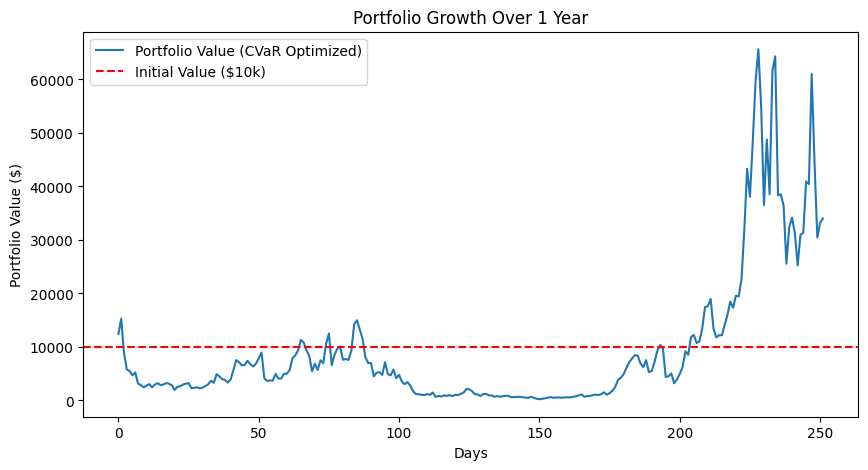

In [ ]:
import numpy as np
import pandas as pd

# Simulating daily returns for 5 stocks over 252 trading days (~1 year)
np.random.seed(42)
n_days = 252
n_stocks = 5

# Generate random daily returns (mean ~0.0005, std dev ~0.02)
simulated_returns = np.random.normal(0.0005, 0.02, (n_days, n_stocks))
returns_df = pd.DataFrame(simulated_returns, columns=[f"Stock_{i+1}" for i in range(n_stocks)])

# Initial portfolio value
initial_value = 10000

# Portfolio weights optimized using CVaR (for simplicity, assume equal-weighted)
cvar_weights = np.full(n_stocks, n_stocks)  # 20% allocation to each stock

# Compute portfolio daily returns
portfolio_returns = returns_df @ cvar_weights  # Weighted sum of returns

# Compute cumulative returns and portfolio value
cumulative_returns = (1 + portfolio_returns).cumprod()
portfolio_values = initial_value * cumulative_returns

# Display final portfolio value
final_value = portfolio_values.iloc[-1]
print(f"Final Portfolio Value after 1 year: ${final_value:.2f}")

# Plot portfolio value over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_values, label="Portfolio Value (CVaR Optimized)")
plt.axhline(y=initial_value, color='r', linestyle='--', label="Initial Value ($10k)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Growth Over 1 Year")
plt.legend()
plt.show()
